<a target="_blank" href="https://colab.research.google.com/github/Sebelino/DD2424-project/blob/main/e1_sebastian.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
from determinism import Determinism

determinism = Determinism(seed=43).sow()  # Keep this before any torch import
print("Training results should now be reproducible.")


Training results should now be reproducible.


# Train model

Training with params:
{
  "seed": 43,
  "architecture": "resnet50",
  "optimizer": {
    "learning_rate": 0.004713842776302303,
    "weight_decay": 4.287389519996026e-06,
    "momentum": 0.7222321829989696,
    "name": "nag"
  },
  "n_epochs": 40,
  "freeze_layers": true,
  "augmentation": {
    "enabled": true,
    "transform": "Compose(\n    RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)\n    RandomHorizontalFlip(p=0.5)\n    ToTensor()\n    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])\n)",
    "dropout_rate": 0.3
  },
  "validation_freq": 1,
  "val_acc_target": 0.98,
  "mft": {
    "enabled": false,
    "k": 0
  },
  "unfreeze_last_l_blocks": 5,
  "fixmatch": false,
  "unsup_weight": 0.5,
  "contrastive_temp": 0.1,
  "num_classes": 37,
  "use_scheduler": true,
  "scheduler_type": "plateau"
}
[Trainer] Unfroze last 5 blocks


Update step:   0%|          | 0/4160 [00:00<?, ?it/s]

Epoch [1/40], Loss: 2.5122, Train Acc: 54.63%, Val Acc: 90.14%
Epoch [2/40], Loss: 0.6563, Train Acc: 88.63%, Val Acc: 92.05%
Epoch [3/40], Loss: 0.3451, Train Acc: 92.13%, Val Acc: 94.79%
Epoch [4/40], Loss: 0.2381, Train Acc: 94.09%, Val Acc: 93.15%
Epoch [5/40], Loss: 0.1675, Train Acc: 95.99%, Val Acc: 94.25%
Epoch [6/40], Loss: 0.1407, Train Acc: 96.50%, Val Acc: 94.25%
Epoch [7/40], Loss: 0.1169, Train Acc: 96.95%, Val Acc: 94.25%
Epoch [8/40], Loss: 0.0898, Train Acc: 97.95%, Val Acc: 96.16%
Epoch [9/40], Loss: 0.0829, Train Acc: 98.01%, Val Acc: 94.79%
Epoch [10/40], Loss: 0.0658, Train Acc: 98.46%, Val Acc: 96.16%
Epoch [11/40], Loss: 0.0501, Train Acc: 99.03%, Val Acc: 94.52%
Epoch [12/40], Loss: 0.0495, Train Acc: 98.88%, Val Acc: 95.07%
Epoch [13/40], Loss: 0.0387, Train Acc: 99.52%, Val Acc: 95.62%
Epoch [14/40], Loss: 0.0353, Train Acc: 99.52%, Val Acc: 95.34%
Epoch [15/40], Loss: 0.0354, Train Acc: 99.28%, Val Acc: 95.07%
Epoch [16/40], Loss: 0.0271, Train Acc: 99.55%, V

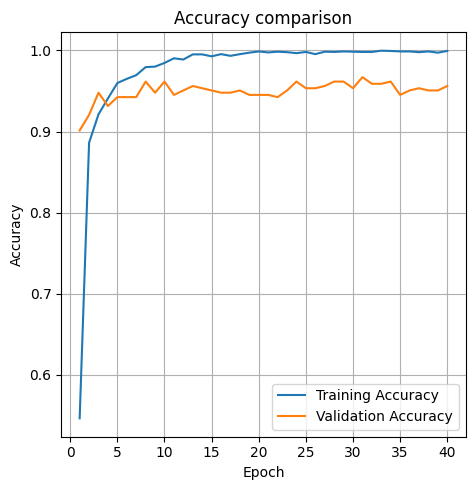

In [11]:
from typing import Literal
import augmentation
from augmentation import AugmentationParams
%reload_ext autoreload
%autoreload 2

from training import TrainParams, NagParams
from evaluation import evaluate_test_accuracy_and_misclassified, \
    evaluate_with_train_val_plot, run_with_different_seeds
from run import run
from caching import invalidate_cache_entry
from datasets import DatasetParams

dataset_params = DatasetParams(
    splitting_seed=determinism.seed,
    shuffler_seed=determinism.seed,
    batch_size=32,
#     #class_fractions=(0.2,)*37,
#     class_fractions=(1.0,) * 37,
    trainval_size=None,
    validation_set_fraction=0.1,  # 20 % of trainval set
)

architecture: Literal["resnet18", "resnet34", "resnet50"] = "resnet50"
baseline_params = TrainParams(
    seed=determinism.seed,
    architecture=architecture,
    n_epochs=40,
    optimizer=NagParams(
        learning_rate=0.004713842776302303,
        weight_decay=4.287389519996026e-06,
        momentum=0.7222321829989696,
    ),
    freeze_layers=True,
    unfreezing_epochs=None,
    augmentation=AugmentationParams(
        enabled=True,
        transform=augmentation.to_transform(architecture, ["resize", "flip"]),
#         dropout_rate=0.485732545717694
        dropout_rate= 0.3
    ),
    validation_freq=1,
    time_limit_seconds=None,
    val_acc_target=0.98,
    unfreeze_last_l_blocks=5,
    use_scheduler=True,               
    scheduler_type="plateau"         
)


run_args = (dataset_params, baseline_params, determinism)

# Set invalidate=True to invalidate a single cache entry
invalidate_cache_entry(run, run_args, invalidate=False)

# First plot: Training and validation accuracy
print("Training with params:")
print(baseline_params.pprint())
result = run(*run_args)

print("Training result:")
print(result.pprint())
evaluate_with_train_val_plot(result)



# import matplotlib.pyplot as plt

# # Plot training and validation accuracy
# epochs = result.epochs
# train_acc = result.training_accuracies
# val_acc = result.validation_accuracies

# plt.figure(figsize=(10, 5))
# plt.plot(epochs, train_acc, label="Training Accuracy")
# plt.plot(epochs, val_acc, label="Validation Accuracy")
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy")
# plt.title("Training and Validation Accuracy")
# plt.legend()
# plt.grid(True)

# plt.savefig("accuracy_plot.png", dpi=300)
# print("Saved plot to 'accuracy_plot.png'")
# plt.show()



In [6]:
# #unfreeze_last_l_blocks=2

# from torchvision import transforms
# from run import try_loading_trainer
# from evaluation import evaluate_test_accuracy
# from torch.utils.data import DataLoader
# from datasets import load_dataset
# from training import Trainer
# from util import suppress_weights_only_warning

# suppress_weights_only_warning()

# eval_params = baseline_params.copy()

# trainer = try_loading_trainer(dataset_params, eval_params, determinism)

# test_dataset = load_dataset("test", Trainer.make_base_transform(eval_params))
# test_loader = DataLoader(
#     test_dataset,
#     batch_size=dataset_params.batch_size,
#     shuffle=False,
#     num_workers=3,
#     persistent_workers=False,
#     pin_memory=True,
#     worker_init_fn=Determinism.data_loader_worker_init_fn(dataset_params.shuffler_seed),
# )
# print(f"Test size: {len(test_loader.dataset)}")

# final_test_acc = evaluate_test_accuracy(trainer, test_loader)

# print(f"Final Test Accuracy: {final_test_acc:.2f}%")

Trying to load trainer from disk...
[Warning] Failed to load optimizer state_dict: loaded state dict contains a parameter group that doesn't match the size of optimizer's group
[Trainer] Loaded checkpoint from runs/checkpoints/7ec96c8c158ab816fa86bd20f8235079.pth (epoch 40)
Test size: 3669


/opt/python/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Final Test Accuracy: 93.02%


In [8]:
# #unfreeze_last_l_blocks=3

# from torchvision import transforms
# from run import try_loading_trainer
# from evaluation import evaluate_test_accuracy
# from torch.utils.data import DataLoader
# from datasets import load_dataset
# from training import Trainer
# from util import suppress_weights_only_warning

# suppress_weights_only_warning()

# eval_params = baseline_params.copy()

# trainer = try_loading_trainer(dataset_params, eval_params, determinism)

# test_dataset = load_dataset("test", Trainer.make_base_transform(eval_params))
# test_loader = DataLoader(
#     test_dataset,
#     batch_size=dataset_params.batch_size,
#     shuffle=False,
#     num_workers=3,
#     persistent_workers=False,
#     pin_memory=True,
#     worker_init_fn=Determinism.data_loader_worker_init_fn(dataset_params.shuffler_seed),
# )
# print(f"Test size: {len(test_loader.dataset)}")

# final_test_acc = evaluate_test_accuracy(trainer, test_loader)

# print(f"Final Test Accuracy: {final_test_acc:.2f}%")

Trying to load trainer from disk...


/opt/python/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[Warning] Failed to load optimizer state_dict: loaded state dict contains a parameter group that doesn't match the size of optimizer's group
[Trainer] Loaded checkpoint from runs/checkpoints/5259a782fff11c925ca588ca2d71c0f8.pth (epoch 40)
Test size: 3669


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Final Test Accuracy: 93.10%


In [10]:
# #unfreeze_last_l_blocks=4

# from torchvision import transforms
# from run import try_loading_trainer
# from evaluation import evaluate_test_accuracy
# from torch.utils.data import DataLoader
# from datasets import load_dataset
# from training import Trainer
# from util import suppress_weights_only_warning

# suppress_weights_only_warning()

# eval_params = baseline_params.copy()

# trainer = try_loading_trainer(dataset_params, eval_params, determinism)

# test_dataset = load_dataset("test", Trainer.make_base_transform(eval_params))
# test_loader = DataLoader(
#     test_dataset,
#     batch_size=dataset_params.batch_size,
#     shuffle=False,
#     num_workers=3,
#     persistent_workers=False,
#     pin_memory=True,
#     worker_init_fn=Determinism.data_loader_worker_init_fn(dataset_params.shuffler_seed),
# )
# print(f"Test size: {len(test_loader.dataset)}")

# final_test_acc = evaluate_test_accuracy(trainer, test_loader)

# print(f"Final Test Accuracy: {final_test_acc:.2f}%")

Trying to load trainer from disk...


/opt/python/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[Warning] Failed to load optimizer state_dict: loaded state dict contains a parameter group that doesn't match the size of optimizer's group
[Trainer] Loaded checkpoint from runs/checkpoints/50e90dc36fade7461e84123e26bec09d.pth (epoch 40)
Test size: 3669


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Final Test Accuracy: 92.91%


In [12]:
#unfreeze_last_l_blocks=5

from torchvision import transforms
from run import try_loading_trainer
from evaluation import evaluate_test_accuracy
from torch.utils.data import DataLoader
from datasets import load_dataset
from training import Trainer
from util import suppress_weights_only_warning

suppress_weights_only_warning()

eval_params = baseline_params.copy()

trainer = try_loading_trainer(dataset_params, eval_params, determinism)

test_dataset = load_dataset("test", Trainer.make_base_transform(eval_params))
test_loader = DataLoader(
    test_dataset,
    batch_size=dataset_params.batch_size,
    shuffle=False,
    num_workers=3,
    persistent_workers=False,
    pin_memory=True,
    worker_init_fn=Determinism.data_loader_worker_init_fn(dataset_params.shuffler_seed),
)
print(f"Test size: {len(test_loader.dataset)}")

final_test_acc = evaluate_test_accuracy(trainer, test_loader)

print(f"Final Test Accuracy: {final_test_acc:.2f}%")

Trying to load trainer from disk...


/opt/python/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[Warning] Failed to load optimizer state_dict: loaded state dict contains a parameter group that doesn't match the size of optimizer's group
[Trainer] Loaded checkpoint from runs/checkpoints/a75e60081d316330680308449ee339fa.pth (epoch 40)
Test size: 3669


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Final Test Accuracy: 92.97%
